## Семинар 6: "Архитектуры и transfer learning"

ФИО:  Дегтярев Роман Олегович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models
import pandas as pd
import os
from skimage import io, transform
from torchvision import models,transforms,datasets
import time
from tqdm import tqdm


%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [2]:
#зададим папки
train_landmarks_path = 'dataset/train/face_landmarks.csv'
train_path = 'dataset/train'
test_landmarks_path = 'dataset/test/face_landmarks.csv'
test_path = 'dataset/test'

In [5]:
#зададим модель
model_vgg = models.vgg16(pretrained=True)

In [6]:
model_vgg

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [7]:
class ConvNet_2(torch.nn.Module):
    def __init__(self):
        super(ConvNet_2, self).__init__()
        
        #это нужно потому, что модель принимает на вход (N, 3, 224, 224)
        #как я понял, эта функция грамотно расширяет картинку меньшей размерности до нужной по ближайшим точкам
        self.convert = torch.nn.UpsamplingNearest2d(size = (224,224))
        self.feature_extractor = model_vgg.features
        for param in model_vgg.parameters():
            param.requires_grad = False
                
        self.linear_layers = torch.nn.Sequential(
          #если посмотреть внимательно model_vgg, то выход со свёрточных слоёв будет именно таким
          torch.nn.Linear(25088, 330),
          torch.nn.Sigmoid(),
          torch.nn.Linear(330, 136)
        )
    
    def forward(self, x):
        x = self.convert(x)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    def predict_proba(self,x):
        return torch.exp(self.forward(x))
    
    def predict(self,x):
        return self.predict_proba(x).data.numpy().argmax(axis=1)


In [8]:
#считаем данные
#для этого зададим класс, отнаследованный от dataset. 
# у этого класса будет методы: инициализация и вернуть картинку
class faces(Dataset):
    def __init__(self, csv_file, root_dir, transform= None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [9]:
train = faces(csv_file=train_landmarks_path,
                             root_dir= train_path, 
                             transform=transforms.Compose([ToTensor()])
             )

In [10]:
dataloader = DataLoader(train, batch_size=40,
                        shuffle=True)

In [11]:
model = ConvNet_2()

In [13]:
loss_fn = torch.nn.MSELoss(size_average=True)
model = ConvNet_2()
error = []
error_train = []
optimizer =  torch.optim.SGD(model.linear_layers.parameters(), lr=1e-3)
for t in range(10):
    for T in tqdm(dataloader):
        X = T['image']
        X = torch.stack((X,)*3).float()
        X = X.view(X.size(1), X.size(0), 96, 96)
        X = X.resize_(X.size(0), X.size(1), 56, 56)
        Y = T['landmarks'].view(T['landmarks'].size(0), -1).type(torch.FloatTensor)
        x = Variable(X, requires_grad=False)
        y = Variable(Y, requires_grad=False)
        
        y_pred = model(x)

        loss =  loss_fn(y_pred, y)
        error.append(loss.data[0])
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    print ('epoch %d, meanerror %f' % (t,  np.array(error).mean()))
    error_train.append(np.array(error).mean())

In [ ]:
#Но это долго и неоптимально, лучше сделать все преобразования, которые мы можем, за циклом.

In [14]:
#тут нужно было достать картинки, незнамо как это сделать у dataloader'a
#я воспользовался лайфхаком питона
p=0
for T in dataloader:
    p = T['image']
    break

In [15]:
X = p
X = torch.stack((X,)*3).float()
X = X.view(X.size(1), X.size(0), 96, 96)
X = X.resize_(X.size(0), X.size(1), 56, 56)
m = torch.nn.UpsamplingNearest2d(size = (224,224))
x = Variable(X, requires_grad=False)
x = m(x)

In [16]:
#всё, что я делаю выше, нужно для того, что модель принимает на вход батч (N, 3, 224, 224)
#Как узнать две последние цифры, кроме как спросить на форуме или у преподавателя, пока не ясно.
x = model_vgg.features(x)
x = x.view(x.size(0), -1)

In [26]:
lin_model = torch.nn.Sequential(
          torch.nn.Linear(25088, 330),
          torch.nn.Sigmoid(),
          torch.nn.Linear(330, 136)
        )
loss_fn = torch.nn.MSELoss(size_average=True)
error = []
error_train = []
optimizer =  torch.optim.SGD(lin_model.parameters(), lr=1e-3)
for t in tqdm(range(15)):
    for i,T in enumerate(dataloader):
        Y = T['landmarks'].view(T['landmarks'].size(0), -1).float()
        y = Variable(Y, requires_grad=False)
        y_pred = lin_model.forward(x)

        loss =  loss_fn(y_pred, y)
        error.append(loss.data[0])
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        if i==154:
            break
    print ('epoch %d, meanerror %f' % (t,  np.array(error).mean()))
    error_train.append(np.array(error).mean())


  0%|          | 0/15 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/romandegtyarev/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/romandegtyarev/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/romandegtyarev/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  7%|▋         | 1/15 [00:28<06:38, 28.46s/it]

epoch 0, meanerror 2230.085175



 13%|█▎        | 2/15 [00:56<06:09, 28.45s/it]

epoch 1, meanerror 1602.314096



 20%|██        | 3/15 [01:27<05:49, 29.11s/it]

epoch 2, meanerror 1211.186294



 27%|██▋       | 4/15 [01:54<05:14, 28.62s/it]

epoch 3, meanerror 956.981465



 33%|███▎      | 5/15 [02:18<04:37, 27.79s/it]

epoch 4, meanerror 784.283780



 40%|████      | 6/15 [02:43<04:04, 27.17s/it]

epoch 5, meanerror 661.930249



 47%|████▋     | 7/15 [03:09<03:36, 27.02s/it]

epoch 6, meanerror 571.875772



 53%|█████▎    | 8/15 [03:39<03:12, 27.44s/it]

epoch 7, meanerror 503.332241



 60%|██████    | 9/15 [04:12<02:48, 28.07s/it]

epoch 8, meanerror 449.637353



 67%|██████▋   | 10/15 [04:44<02:22, 28.42s/it]

epoch 9, meanerror 406.534949



 73%|███████▎  | 11/15 [05:15<01:54, 28.71s/it]

epoch 10, meanerror 371.212715



 80%|████████  | 12/15 [05:42<01:25, 28.51s/it]

epoch 11, meanerror 341.751633



 87%|████████▋ | 13/15 [06:08<00:56, 28.32s/it]

epoch 12, meanerror 316.815591



 93%|█████████▎| 14/15 [06:34<00:28, 28.17s/it]

epoch 13, meanerror 295.436328



100%|██████████| 15/15 [07:09<00:00, 28.61s/it]


epoch 14, meanerror 276.907949


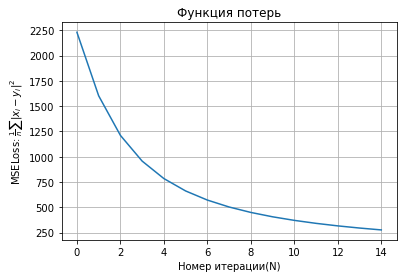

In [36]:
plt.figure()
plt.title(u"Функция потерь")
plt.xlabel(u"Номер итерации(N)")
plt.ylabel(u"MSELoss: $\\frac{1}{n} \sum |x_i-y_i|^2$")
plt.grid()
plt.plot(error_train)

In [37]:
test = faces(csv_file=test_landmarks_path,
            root_dir=test_path, transform=transforms.Compose([ToTensor()])
            )

In [38]:
def predict(model, x_val):
    x_val = torch.stack((x_val,)*3).float()
    x_val = x_val.view(1, 3, 96, 96)
    x_val = x_val.resize_(1, 3, 56, 56)
    m = torch.nn.UpsamplingNearest2d(size = (224,224))
    x_val = Variable(x_val, requires_grad=False)
    x_val = m(x_val)
    x_val = model_vgg.features(x_val)
    x_val = x_val.view(x_val.size(0), -1)
    output = lin_model.forward(x_val)
    return output.data.numpy()

In [39]:
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv(test_landmarks_path)

n = 60
#img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)


def plt_test(i):   
    landmarks = landmarks_frame.ix[i, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)
    plt.figure()
    a = test[i]['image'].float()
    #a = a.view(-1)
    f = predict(model, a)
    f = f[0]
    f_1 = f[::2]
    f_2 = f[1::2]
    img_name = landmarks_frame.ix[i, 0]
    plt.figure()
    plt.imshow(io.imread(os.path.join(test_path, img_name)), cmap='gray')
    plt.scatter(f_1, f_2, s=10, marker='.', c='b')
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

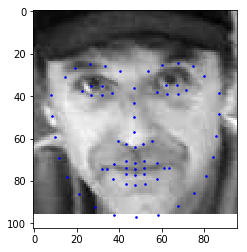

In [40]:
plt_test(5)

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

- Было бы интересно на семинаре узнать некоторые подробности о том, как можно удалять не только последние слои, но и замораживать некоторые свёрточные. А также зачем и когда это могло было бы пригодится.
- Также не очень понятно какой размер тензора подавать на вход претрейн-модели. С этим провозился достаточно долго.
- Если есть возможность, то лучше поподробней останавливайтесь на размерах тензора входа/выхода слоёв модели, с этим висишь большинство времени, а не над самой задачей  